In [60]:
from os import listdir
from os.path import isfile, join
import requests
from math import log
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [3]:
data_path = 'dane'
files = [f for f in listdir(data_path) if isfile(join(data_path, f))]
len(files)

1180

In [4]:
#calaculate sizes of files
lawSizes = []
Path(join(data_path, '1993_599.txt')).stat().st_size

for f in files:
    size = Path(join(data_path, f)).stat().st_size
    lawSizes.append((f, size))

In [5]:
#zad 4
lawSizes.sort(key=lambda tup: tup[1], reverse=True)
top50_largest_laws = lawSizes[:50]

In [6]:
def check_if_valid_sentence(lines, i):
    sentence = lines[i]
    if sentence.startswith(' Nr', 0) or \
       re.match(r'^ [0-9]+', sentence) or \
       re.match(r'^ [a|ą|b|c|ć|d|e|ę|f|g|h|i|j|k|l|ł|m|n|ń|o|ó|p|r|s|ś|t|u|w|y|z|ź|ż]', sentence) or \
       re.match(r'^[A|Ą|B|C|Ć|D|E|Ę|F|G|H|I|J|K|L|Ł|M|N|Ń|O|Ó|P|R|S|Ś|T|U|W|Y|Z|Ź|Ż]', sentence) or \
       re.match(r'^\n[0-9]+', sentence):
        return False
    return True
    

def split_into_sentences(text):
    lines = []
    correct_sentences = []
    j = 0
    lines = text.split('.')
    
    for i, l in enumerate(lines):
        #print(l, check_if_valid_sentence(lines, i))
        if not check_if_valid_sentence(lines, i):
            correct_sentences[j-1] = correct_sentences[j-1] + '.' + lines[i]
        else:
            correct_sentences.append(lines[i])
            j = j+1
        
    return correct_sentences

In [7]:
correct_sentences_per_document = []
for filename, size in top50_largest_laws:   
    with open(data_path +'/' + filename, 'r', encoding = 'utf-8') as f:
        text = f.read()
        correct_sentences_per_document.append(split_into_sentences(text))

In [8]:
correct_sentences_per_document[0][5]

' Minister właściwy do spraw wewnętrznych prowadzi rejestr\n       nieruchomości, udziałów i akcji, nabytych lub objętych przez\n       cudzoziemców bez zezwolenia w przypadkach określonych w art. 8 ust. 1\n       oraz rejestr nieruchomości, udziałów i akcji nabytych lub objętych\n       przez cudzoziemców na podstawie wymaganych zezwoleń, o których mowa w\n       art. 1 ust. 1 oraz w art. 3e ust. 1 i 3'

In [9]:
def ommit_if_not_capital_letter_first_in_sentence(documents):
    for d in documents:
        for num, s in enumerate(d):
            j = 0
            for letter in s:
                if not re.match(r'[A|Ą|B|C|Ć|D|E|Ę|F|G|H|I|J|K|L|Ł|M|N|Ń|O|Ó|P|R|S|Ś|T|U|W|Y|Z|Ź|Ż]', letter):
                    j = j+1
                else:
                    break
            d[num] = s[j:]

In [10]:
ommit_if_not_capital_letter_first_in_sentence(correct_sentences_per_document)

In [11]:
sentences_per_document = []
for d in correct_sentences_per_document:
    sentences_per_document.append([s for s in d if s != ''])

In [12]:
sentences_per_document[0][4]

'Minister właściwy do spraw wewnętrznych prowadzi rejestr\n       nieruchomości, udziałów i akcji, nabytych lub objętych przez\n       cudzoziemców bez zezwolenia w przypadkach określonych w art. 8 ust. 1\n       oraz rejestr nieruchomości, udziałów i akcji nabytych lub objętych\n       przez cudzoziemców na podstawie wymaganych zezwoleń, o których mowa w\n       art. 1 ust. 1 oraz w art. 3e ust. 1 i 3'

In [13]:
url = 'http://localhost:9200'

j = 0
lemmatized_sentences_per_doc = []

# for document in sentences_per_document:
#     doc_lemmatized_sentences = []
    
#     for sentence in document:
#         text = requests.post(url, data = sentence.encode('utf-8'), headers={'Content-type': 'text/plain; charset=utf-8'}).text      
#         doc_lemmatized_sentences.append(text)
        
#     lemmatized_sentences_per_doc.append(doc_lemmatized_sentences)      
#     print(j)
#     j = j+1

In [14]:
import pickle
# with open('laws_l', 'wb') as f:
#     pickle.dump(lemmatized_sentences_per_doc, f)
    
with open('laws_l', 'rb') as f:
    lemmatized_sentences_per_doc = pickle.load(f)

In [15]:
split_lemmatized_sentences_per_doc = []
for doc in lemmatized_sentences_per_doc:
    doc_split_s = []
    for s in doc:
        split_s = [line.split('\t') for line in s.split('\n') if line != '']
        doc_split_s.append(split_s)
    split_lemmatized_sentences_per_doc.append(doc_split_s)   

In [16]:
#split_lemmatized_sentences_per_doc[0][5]

In [17]:
capiatalized_exp = []
for s_doc in split_lemmatized_sentences_per_doc:
    for split_s in s_doc:
        found_capitalized_exp = False
        #ommit capitalized first world
        for i in range(2, len(split_s), 2):
            sentence = split_s[i][0]
            if sentence[0].isupper():
                not_inflected_form = split_s[i+1][1].title()      
                if found_capitalized_exp:
                    #this world is a part of last expression, so concat
                    not_inflected_form_of_all_expr = capiatalized_exp[-1][1] + ' ' + not_inflected_form
                    capiatalized_exp[-1] = (capiatalized_exp[-1][0] + ' ' + sentence, not_inflected_form_of_all_expr)
                else:
                    #new expr encounter
                    capiatalized_exp.append((sentence, not_inflected_form))
                    found_capitalized_exp = True
            else:
                found_capitalized_exp = False            

In [18]:
#change to dict
capiatalized_exp_dict = {}
for expr, not_inflected_from in capiatalized_exp:
    if not_inflected_from in capiatalized_exp_dict.keys():
        capiatalized_exp_dict[not_inflected_from][1].add(expr)
        new_count = count = capiatalized_exp_dict[not_inflected_from][0] +1
        capiatalized_exp_dict[not_inflected_from] = (new_count, capiatalized_exp_dict[not_inflected_from][1])
    else:
        capiatalized_exp_dict[not_inflected_from] = (1, {expr})

#filtered one world expressions 
filtered_capiatalized_exp_dict = {k:v for k, v in capiatalized_exp_dict.items() if len(k.split(' ')) > 1}

In [19]:
#zad 5
capiatalized_exp_dict

{'Ustawa': (1000, {'U', 'USTAWA', 'USTAWY', 'Ustawa'}),
 'Numer': (7779, {'Nr'}),
 'Dziennik': (1162, {'DZ', 'Dz'}),
 'Minister': (279,
  {'Minister',
   'Ministra',
   'Ministrami',
   'Ministrem',
   'Ministrowi',
   'Ministrowie',
   'Ministrów'}),
 'Artykuł': (1028, {'Art'}),
 'Sprawa Wewnętrzny': (50, {'Spraw Wewnętrznych'}),
 'Minister Sprawa Wewnętrzny': (73,
  {'Minister Spraw Wewnętrznych',
   'Ministra Spraw Wewnętrznych',
   'Ministrem Spraw Wewnętrznych',
   'Ministrowi Spraw Wewnętrznych',
   'Ministrze Spraw Wewnętrznych'}),
 'Prawo': (81, {'Prawa', 'Prawo'}),
 'Administracja': (105, {'Administracji'}),
 'Ziemia Odzyskać': (4, {'Ziem Odzyskanych', 'Ziemiach Odzyskanych'}),
 'Miasto Gdańsk': (2, {'Miasta Gdańska'}),
 'I': (177, {'I'}),
 'U': (140, {'U'}),
 'Wojewoda': (11, {'Wojewoda'}),
 'Powiatowy': (5, {'Powiatowe', 'Powiatowy'}),
 'Wydawanie': (1, {'Wydawanie'}),
 'Prezydent': (8, {'Prezydent', 'Prezydenta'}),
 'Warszawa Centrum': (2, {'Warszawa Centrum'}),
 'Polska': 

In [20]:
#zad 6
top_50_non_filtered = [(k, v) for k, v in sorted(capiatalized_exp_dict.items(), key=lambda item: item[1][0], reverse=True)][:50]
top_50_non_filtered

[('Numer', (7779, {'Nr'})),
 ('Dziennik', (1162, {'DZ', 'Dz'})),
 ('Artykuł', (1028, {'Art'})),
 ('Ustawa', (1000, {'U', 'USTAWA', 'USTAWY', 'Ustawa'})),
 ('Rzeczpospolita Polski',
  (688,
   {'Rzeczpospolita Polska',
    'Rzeczpospolitej Polskiej',
    'Rzeczpospolitą Polską',
    'Rzeczypospolitej Polskiej',
    'Rzecząpospolitą Polską'})),
 ('Policja', (432, {'Policja', 'Policji', 'Policją', 'Policję'})),
 ('Kodeks', (420, {'Kodeks', 'Kodeksem', 'Kodeksie', 'Kodeksu'})),
 ('Skarb Państwo',
  (384,
   {'Skarb Państwa',
    'Skarbem Państwa',
    'Skarbowi Państwa',
    'Skarbu Państwa'})),
 ('Dzieje Apostolskie', (350, {'Dz'})),
 ('Kasa Chory',
  (320,
   {'Kas Chorych',
    'Kasa Chorych',
    'Kasach Chorych',
    'Kasami Chorych',
    'Kasie Chorych',
    'Kasom Chorych',
    'Kasy Chorych',
    'Kasą Chorych',
    'Kasę Chorych'})),
 ('Unia Europejski',
  (288, {'Unia Europejska', 'Unii Europejskiej', 'Unią Europejską'})),
 ('Minister',
  (279,
   {'Minister',
    'Ministra',
   

In [21]:
top_50_filtered = [(k, v) for k, v in sorted(filtered_capiatalized_exp_dict.items(), key=lambda item: item[1][0], reverse=True)][:50]
top_50_filtered

[('Rzeczpospolita Polski',
  (688,
   {'Rzeczpospolita Polska',
    'Rzeczpospolitej Polskiej',
    'Rzeczpospolitą Polską',
    'Rzeczypospolitej Polskiej',
    'Rzecząpospolitą Polską'})),
 ('Skarb Państwo',
  (384,
   {'Skarb Państwa',
    'Skarbem Państwa',
    'Skarbowi Państwa',
    'Skarbu Państwa'})),
 ('Dzieje Apostolskie', (350, {'Dz'})),
 ('Kasa Chory',
  (320,
   {'Kas Chorych',
    'Kasa Chorych',
    'Kasach Chorych',
    'Kasami Chorych',
    'Kasie Chorych',
    'Kasom Chorych',
    'Kasy Chorych',
    'Kasą Chorych',
    'Kasę Chorych'})),
 ('Unia Europejski',
  (288, {'Unia Europejska', 'Unii Europejskiej', 'Unią Europejską'})),
 ('Straż Graniczny',
  (272,
   {'Straż Graniczna',
    'Straż Graniczną',
    'Straży Granicznej',
    'Strażą Graniczną'})),
 ('Rada Minister',
  (269,
   {'Rada Ministrów',
    'Rady Ministrów',
    'Radzie Ministrów',
    'Radę Ministrów'})),
 ('Państwowy Straż Pożarny',
  (238,
   {'Państwowa Straż Pożarna',
    'Państwowego Straży Pożarn

In [30]:
#zad 7
#some code from https://github.com/CLARIN-PL/NlpRest2-Tutorials
import json
import requests

base_url = 'http://ws.clarin-pl.eu/nlprest2/base'
lpmn = 'any2txt|wcrft2|liner2({"model":"n82"})'

#upload
tasks = []
for law in top50_largest_laws:
    filename = law[0]
    with open(data_path +'/' + filename, 'r', encoding = 'utf-8') as f:
        text = f.read()
        tasks.append(requests.post(url="http://ws.clarin-pl.eu/nlprest2/base/startTask", json={"text": text, "lpmn": lpmn, "user": ''}).text)

In [40]:
import time

#download result
for task_id in tasks:
    processing = True
    while processing:
        response = json.loads(requests.get(base_url + "/getStatus/" + task_id).text)
        print(response)
        if response['status'] in ["QUEUE", "PROCESSING"]:
            time.sleep(1)
        elif response['status'] == "DONE":
            file_id = response["value"][0]["fileID"]
            response = requests.get(url=base_url + "/download" + file_id)
            with open("ccl/" + task_id, 'w', encoding="utf-8") as file:
                file.write(response.content.decode("utf-8"))
            print("Loaded:", task_id)
            processing = False
        else:
            print("FAIL ", task_id)
            processing = False

{'value': [{'name': 'file', 'fileID': '/requests/liner2/7fad28d8-fc27-4403-8254-94e75ee1448b'}], 'status': 'DONE'}
Loaded: 6cdd9c03-a1f5-42bc-9034-1bc38476e08d
{'value': [{'name': 'file', 'fileID': '/requests/liner2/658007bb-9bce-457c-b186-a9c122d4a57f'}], 'status': 'DONE'}
Loaded: 33a83f85-0174-4abc-a329-779dbd2df435
{'value': [{'name': 'file', 'fileID': '/requests/liner2/075f3f79-a4c6-4776-bd5c-a6bb91486a83'}], 'status': 'DONE'}
Loaded: f7a51346-5562-4d99-9a25-c7522f439b01
{'value': [{'name': 'file', 'fileID': '/requests/liner2/520525ae-a98c-4533-9b83-5522904dc2ee'}], 'status': 'DONE'}
Loaded: be49bc71-1dc1-49f1-8fe1-13002ad91ae0
{'value': [{'name': 'file', 'fileID': '/requests/liner2/8ca8aa95-851d-484e-9bd5-dfbbb92a5654'}], 'status': 'DONE'}
Loaded: f2cd6373-63e3-4e08-9ec5-83fdba638746
{'value': [{'name': 'file', 'fileID': '/requests/liner2/00706c41-e98b-4435-a977-e9bf5164fa0d'}], 'status': 'DONE'}
Loaded: d63616a4-e24f-4315-b2a9-d0574463eac0
{'value': [{'name': 'file', 'fileID': '/

In [43]:
class Token:    
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag
        
    def get_orth(self):
        return self.orth
        

class Annotation:    
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()
        
    def get_category(self):
        return self.category
    
    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens])
    
    def get_lemma(self):
        return self.lemma
    
import xml.etree.ElementTree as ET
def sentence_ner(sentence):
    channels = {}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):            
            index = int(channel.text)
            chan = channel.attrib["chan"]            
            if index > 0:                
                channels.setdefault(chan, {}).setdefault(index, []).append(t)
                
    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():            
            an = Annotation(ann_type, tokens)
            annotations.append(an)
    
    return annotations


def ccl_ner(file):
    tree = ET.parse(file)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations

In [54]:
#zad 8 
coarse_grained_classes_freq = {}
coarse_grained_classes_elems_with_freq = {}

for task_id in tasks:
    annotations = ccl_ner("ccl/" + task_id)
    for annotation in annotations:
        category = "_".join(annotation.get_category().split("_")[:2])
        entity = annotation.get_lemma()

        if category in coarse_grained_classes_freq.keys():
            coarse_grained_classes_freq[category] += 1
            if entity in coarse_grained_classes_elems_with_freq[category]:
                coarse_grained_classes_elems_with_freq[category][entity] += 1    
            else:
                coarse_grained_classes_elems_with_freq[category][entity] = 1
                
        else:
            coarse_grained_classes_freq[category] = 1
            coarse_grained_classes_elems_with_freq[category] = {}
            coarse_grained_classes_elems_with_freq[category][entity] = 1

In [58]:
sorted_coarse_grained_classes_freq = {k: v for k, v in sorted(coarse_grained_classes_freq.items(), key=lambda item: item[1], reverse=True)}

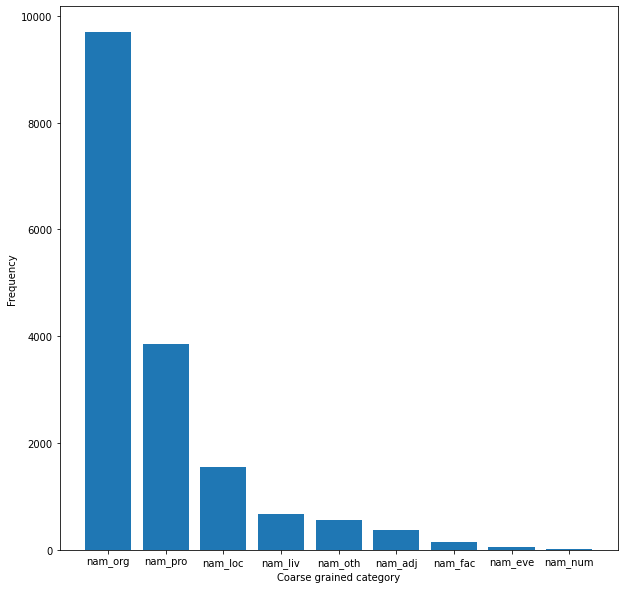

In [67]:
plt.figure(figsize=(10, 10))
plt.bar(list(sorted_coarse_grained_classes_freq.keys()), sorted_coarse_grained_classes_freq.values())
plt.xlabel("Coarse grained category")
plt.ylabel("Frequency")
plt.show()

In [78]:
#zad 9 
for category, elems_woth_freq in coarse_grained_classes_elems_with_freq.items():
    sorted_elems_woth_freq = {k: v for k, v in sorted(elems_woth_freq.items(), key=lambda item: item[1], reverse=True)}
    print(category)
    for i in list(sorted_elems_woth_freq.items())[:10]:
        print(i)

nam_pro
('Dz . U .', 1577)
('Times', 205)
('Times New Roman', 90)
('Dz . Urz', 81)
('Ordynacja podatkowa', 77)
('Kodeksu karnego', 64)
('Monitor Polski', 62)
('Znak', 58)
('Spraw Wewnętrznych', 51)
('Kodeksu postępowania administracyjnego', 35)
nam_org
('Unii Europejskiej', 302)
('Skarbu Państwa', 291)
('Rada Ministrów', 261)
('Państwowej Straży Pożarnej', 237)
('Minister Sprawiedliwości', 232)
('Prezes Rady Ministrów', 212)
('Minister Obrony Narodowej', 154)
('Minister Finansów', 151)
('Urzędu Ochrony Państwa', 132)
('EFTA', 114)
nam_loc
('Rzeczypospolitej Polskiej', 815)
('Rzeczpospolita Polska', 56)
('Polsce', 51)
('Rzeczpospolitą Polską', 41)
('Warszawie', 32)
('Warszawy', 20)
('Nawóz', 19)
('Warszawa', 16)
('Konfederacji Szwajcarskiej', 11)
('Polską', 10)
nam_liv
('Kasa Chorych', 51)
('Straży Granicznej', 36)
('Sił Zbrojnych', 24)
('Kasy Chorych', 21)
('Art', 18)
('Pana', 18)
('Gospodarki Żywnościowej', 16)
('Krajowego Depozytu', 15)
('Pan', 15)
('Kas Chorych', 13)
nam_eve
('EURO'

In [91]:
#zad 10
all_vals = []
for category, vals in coarse_grained_classes_elems_with_freq.items():
    all_vals.extend([(v, category) for v in list(vals.items())])
all_vals.

(('Dz . U .', 1577), 'nam_pro')

In [95]:
sorted_all_vals = sorted(all_vals, key=lambda tup: tup[0][1], reverse=True)
sorted_all_vals[:50]

[(('Dz . U .', 1577), 'nam_pro'),
 (('Rzeczypospolitej Polskiej', 815), 'nam_loc'),
 (('Unii Europejskiej', 302), 'nam_org'),
 (('zł', 293), 'nam_oth'),
 (('Skarbu Państwa', 291), 'nam_org'),
 (('Rada Ministrów', 261), 'nam_org'),
 (('Państwowej Straży Pożarnej', 237), 'nam_org'),
 (('Minister Sprawiedliwości', 232), 'nam_org'),
 (('Prezes Rady Ministrów', 212), 'nam_org'),
 (('Times', 205), 'nam_pro'),
 (('Minister Obrony Narodowej', 154), 'nam_org'),
 (('Minister Finansów', 151), 'nam_org'),
 (('Urzędu Ochrony Państwa', 132), 'nam_org'),
 (('polski', 116), 'nam_adj'),
 (('EFTA', 114), 'nam_org'),
 (('Państwowa Komisja Wyborcza', 110), 'nam_org'),
 (('Urząd Patentowy', 104), 'nam_org'),
 (('Europejskiego Porozumienia o Wolnym Handlu', 103), 'nam_org'),
 (('Skarb Państwa', 98), 'nam_org'),
 (('Państwowej Komisji Wyborczej', 98), 'nam_org'),
 (('Times New Roman', 90), 'nam_pro'),
 (('euro', 90), 'nam_oth'),
 (('Prezes Urzędu', 88), 'nam_org'),
 (('Dz . Urz', 81), 'nam_pro'),
 (('OKRĘG',

***Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?***
* NER radził sobie trochę lepiej, niż pierwsza metoda. Szczególnie biorąc pod uwagę nazywy własne składające sie z jednego słowa, pierwsza, prymitywna metoda zwróciła sporo nieporawnych słów sklasyfikowanych jako nazwy własne. Natomiast biorąc pod uwagę nazwy własne dłuższe, niż jedno słowa, obie metody radziły sobie dobrze. 

***What are the drawbacks of the method based on capital letters?***
* Metoda ta nie zwraca, do której klasy należy nazwa własna, co mogłoby być przydatna informacją. Dzięki swojej prostocie, niepoprawnie klasyfikuje jako wyrażenia NE wszystkie słowa z dużej litery, występujące w środku zdania (np. Zadanie).

***What are the drawbacks of the method based on NER?***
* Wadą NER jest brak rozpoznawania form tego samego wyrażenia jako jedno wyrażenie np. NER znalazł jako osobne wystąpienia: ('Rzeczypospolitej Polskiej', 815), ('Rzeczpospolita Polska', 56), ('Polsce', 51), ('Rzeczpospolitą Polską', 41).
* Pierwsza metoda z tym problemem sobie poradziła - zwróciła jedną sumą dla kilku odmian: 'Rzeczpospolita Polski': (688, {'Rzeczpospolita Polska','Rzeczpospolitej Polskiej','Rzeczpospolitą Polską','Rzeczypospolitej Polskiej','Rzecząpospolitą Polską'})

***Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.***
* Najlepszą grupą było nam_org (wszystkie zwrócone wyrażenia były poprawnymi nazwami organizacji), natomiast najgorszą nam_num (uzyskanie liczb, najprawdopodobniej uzyskanych z nazwa artykułów, przypisów, nie miało sczególnego znaczenia).

***Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that would be able to group such names together?***
* Tak jak w przykładzie przytoczonym wyżej z Rzeczpospolitą Polską, NER nie poradził sobie z identyfikacją różnych form tej samej nazwy własnej. Rozwiązaniem mogłoby być dla zapisywanie podstawowych form słów tak jak w pierwszej metodzie.

***Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?***
* Proponowanie artykułów zawierających NER (optymalizacja pod względem trafności). 